pca

In [50]:
OHCO = ['genre','author','book_id','chap_num','para_num','sent_num','token_num']

SENTS = OHCO[:6]
PARAS = OHCO[:5]
CHAPS = OHCO[:4]
BOOKS = OHCO[:3]
AUTHOR = OHCO[:2]
GENRE = OHCO[:1]

In [51]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

import os
os.chdir('C:\\Users\\dwagn\\git\\DS5001\\Project')

In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

import seaborn as sns

sns.set(style='ticks')
%matplotlib inline

In [53]:
LIB = pd.read_csv('LIB.csv')
VOCAB = pd.read_csv('VOCAB2.csv').set_index('term_id')
TOKENS = pd.read_csv('TOKEN2.csv')

In [54]:
TOKENS = pd.merge(TOKENS,LIB, how = 'inner', on = 'book_id')

In [55]:
genre = [(141,'n'),(121,'n'), (42671,'n')]
genre_df = pd.DataFrame(genre,columns=('book_id','genre')).set_index('book_id')

In [56]:
LIB = pd.merge(LIB,genre_df, how = 'inner', on = 'book_id')

In [57]:
TOKENS = pd.merge(TOKENS,genre_df, how = 'inner', on = 'book_id')

In [58]:
TOKENS.set_index(OHCO)

pos_tuple  \
genre author book_id chap_num para_num sent_num token_num                            
n     austen 141     49       1        0        0                  ('About', 'IN')   
                                                1                 ('thirty', 'CD')   
                                                2                 ('years', 'NNS')   
                                                3                    ('ago', 'RB')   
                                                4                  ('Miss', 'NNP')   
...                                                                            ...   
             42671   61       19       0        4             ('GUTENBERG', 'NNP')   
                                                5                 ('EBOOK', 'NNP')   
                                                6                 ('PRIDE', 'NNP')   
                                                7                   ('AND', 'NNP')   
                                                8          ('PREJUDICE***', 'NNP')   

                                                           pos     token_str  \
genre author book_id chap_num para_num sent_num token_num                      
n     austen 141     49       1        0        0           IN         About   
                                                1           CD        thirty   
                                                2          NNS         years   
                                                3           RB           ago   
                                                4          NNP          Miss   
...                                                        ...           ...   
             42671   61       19       0        4          NNP     GUTENBERG   
                                                5          NNP         EBOOK   
                                                6          NNP         PRIDE   
                                                7          NNP           AND   
                                                8          NNP  PREJUDICE***   

                                                            term_str  term_id  \
genre author book_id chap_num para_num sent_num token_num                       
n     austen 141     49       1        0        0              about       44   
                                                1             thirty    10554   
                                                2              years    11832   
                                                3                ago      312   
                                                4               miss     6704   
...                                                              ...      ...   
             42671   61       19       0        4          gutenberg     4775   
                                                5              ebook     3362   
                                                6              pride     8018   
                                                7                and      467   
                                                8          prejudice     7939   

                                                                                            book_title  \
genre author book_id chap_num para_num sent_num token_num                                                
n     austen 141     49       1        0        0                       Mansfield Park, by Jane Austen   
                                                1                       Mansfield Park, by Jane Austen   
                                                2                       Mansfield Park, by Jane Austen   
                                                3                       Mansfield Park, by Jane Austen   
                                                4                       Mansfield Park, by Jane Austen   
...                                                                                                ...   
           

In [59]:
TOKENS = TOKENS[~TOKENS.term_str.isna()]

In [60]:
VOCAB['pos_max'] = TOKENS.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1)

if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')

VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1

VOCAB['p'] = VOCAB.n / VOCAB.shape[0]

VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2
VOCAB['zipf_k3'] = VOCAB.p * VOCAB.term_rank2

In [61]:
def TFIDF_Matrix(df,bag,count_type,tf_type,idf_type):

    BOW = TOKENS.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    DF = DTCM[DTCM > 0].count()

    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    TFIDF = TF * IDF

    VOCAB['df'] = DF
    VOCAB['idf'] = IDF

    BOW['tf'] = TF.stack()
    BOW['tfidf'] = TFIDF.stack()

    VOCAB['tfidf_sum'] = TFIDF.sum()

    VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient\
        (cmap=gradient_cmap, high=1)

    VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False).head(50)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False)\
        .head(50).style.background_gradient(cmap=gradient_cmap, high=1)
    
    BOW = BOW.join(VOCAB[['term_str','pos_max']], on='term_id')

    BOW.sort_values('tfidf', ascending=False).head(20)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    return TFIDF

In [62]:
def BOW_Matrix(df,bag,count_type,tf_type,idf_type):

    BOW = TOKENS.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    DF = DTCM[DTCM > 0].count()

    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    TFIDF = TF * IDF

    VOCAB['df'] = DF
    VOCAB['idf'] = IDF

    BOW['tf'] = TF.stack()
    BOW['tfidf'] = TFIDF.stack()

    VOCAB['tfidf_sum'] = TFIDF.sum()

    VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient\
        (cmap=gradient_cmap, high=1)

    VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False).head(50)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False)\
        .head(50).style.background_gradient(cmap=gradient_cmap, high=1)
    
    BOW = BOW.join(VOCAB[['term_str','pos_max']], on='term_id')

    BOW.sort_values('tfidf', ascending=False).head(20)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    return BOW
    

In [63]:
TFIDF = TFIDF_Matrix(TOKENS,BOOKS,count_method,tf_method,idf_method)

In [64]:
BOW = BOW_Matrix(TOKENS,BOOKS,count_method,tf_method,idf_method)

In [65]:
TFIDF

term_id                  1         2         3         4         5      \
genre author book_id                                                     
n     austen 121      0.000006  0.000000  0.000000  0.000000  0.000006   
             141      0.000000  0.000009  0.000006  0.000000  0.000000   
             42671    0.000000  0.000000  0.000000  0.000004  0.000000   

term_id                  6         7         8         9         10     ...  \
genre author book_id                                                    ...   
n     austen 121      0.000012  0.000000  0.000006  0.000006  0.000000  ...   
             141      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
             42671    0.000000  0.000008  0.000000  0.000000  0.000004  ...   

term_id               11873     11874  11875  11876     11877     11878  \
genre author book_id                                                      
n     austen 121        0.0  0.000000    0.0    0.0  0.000012  0.000000   
             141        0.0  0.000000    0.0    0.0  0.000000  0.000000   
             42671      0.0  0.000004    0.0    0.0  0.000000  0.000004   

term_id                  11879     11880     11881     11882  
genre author book_id                                          
n     austen 121      0.000000  0.000000  0.000000  0.000000  
             141      0.000000  0.000015  0.000003  0.000003  
             42671    0.000004  0.000000  0.000000  0.000000  

[3 rows x 11882 columns]

In [66]:
BOW

n  c        tf     tfidf     term_str pos_max
genre author book_id term_id                                               
n     austen 121     1        1  1  0.000013  0.000006            1      JJ
                     5        1  1  0.000013  0.000006       179798      JJ
                     6        2  1  0.000026  0.000012         1803      CD
                     8        1  1  0.000013  0.000006         1816      CD
                     9        1  1  0.000013  0.000006         1818      CD
...                          .. ..       ...       ...          ...     ...
             42671   11874    1  1  0.000008  0.000004  yourselfand      NN
                     11875    2  1  0.000016  0.000000   yourselves      NN
                     11876    9  1  0.000074  0.000000        youth      NN
                     11878    1  1  0.000008  0.000004       youths     NNS
                     11879    1  1  0.000008  0.000004      youwill      VB

[21107 rows x 6 columns]

In [67]:
DTCM = BOW[count_method].unstack().fillna(0).astype('int')

In [68]:
DTCM.head(10)

term_id               1      2      3      4      5      6      7      8      \
genre author book_id                                                           
n     austen 121          1      0      0      0      1      2      0      1   
             141          0      3      2      0      0      0      0      0   
             42671        0      0      0      1      0      0      2      0   

term_id               9      10     ...  11873  11874  11875  11876  11877  \
genre author book_id                ...                                      
n     austen 121          1      0  ...     22      0      1      4      2   
             141          0      0  ...     58      0      3      6      0   
             42671        0      1  ...     49      1      2      9      0   

term_id               11878  11879  11880  11881  11882  
genre author book_id                                     
n     austen 121          0      0      0      0      0  
             141          0      0      5      1      1  
             42671        1      1      0      0      0  

[3 rows x 11882 columns]

In [69]:
reduced_vocab = VOCAB[VOCAB['tfidf_sum']>0]

In [70]:
reduced_vocab

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,
3976,67,fanny,816,0,0,fanni,NNP,67,0.068675,54672,54672,4.601246,1,0.477121,0.002436
3440,90,elizabeth,585,0,0,elizabeth,NNP,89,0.049234,52650,52065,4.381838,1,0.477121,0.002294
1524,95,catherine,538,0,0,catherin,NNP,94,0.045279,51110,50572,4.256186,2,0.176091,0.001132
2402,102,crawford,493,0,0,crawford,NNP,101,0.041491,50286,49793,4.190624,1,0.477121,0.001472
2521,126,darcy,365,0,0,darci,NNP,123,0.030719,45990,44895,3.778404,1,0.477121,0.001431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723,11878,interfered,1,0,0,interf,VBD,374,0.000084,11878,374,0.031476,1,0.477121,0.000003
5716,11879,intercepting,1,0,0,intercept,VBG,374,0.000084,11879,374,0.031476,1,0.477121,0.000006
5715,11880,intercept,1,0,0,intercept,VB,374,0.000084,11880,374,0.031476,1,0.477121,0.000003


In [71]:
reduced_vocab = reduced_vocab.sort_values('tfidf_sum',ascending=False).head(4000)

In [72]:
reduced_vocab

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,
3976,67,fanny,816,0,0,fanni,NNP,67,0.068675,54672,54672,4.601246,1,0.477121,0.002436
3440,90,elizabeth,585,0,0,elizabeth,NNP,89,0.049234,52650,52065,4.381838,1,0.477121,0.002294
2402,102,crawford,493,0,0,crawford,NNP,101,0.041491,50286,49793,4.190624,1,0.477121,0.001472
2521,126,darcy,365,0,0,darci,NNP,123,0.030719,45990,44895,3.778404,1,0.477121,0.001431
10621,228,tilney,196,0,0,tilney,NNP,195,0.016496,44688,38220,3.216630,1,0.477121,0.001207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9075,4871,sakes,3,0,0,sake,NN,372,0.000252,14613,1116,0.093924,2,0.176091,0.000004
479,5517,anguish,3,0,0,anguish,JJ,372,0.000252,16551,1116,0.093924,2,0.176091,0.000004
6941,4772,neglecting,3,0,0,neglect,VBG,372,0.000252,14316,1116,0.093924,2,0.176091,0.000004


In [73]:
terms = list(reduced_vocab.index)

In [74]:
TFIDF = TFIDF.filter(terms)

In [75]:
TFIDF

term_id                  3976      3440      2402      2521      10621  \
genre author book_id                                                     
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.001207   
             141      0.002436  0.000000  0.001472  0.000000  0.000000   
             42671    0.000000  0.002294  0.000000  0.001431  0.000000   

term_id                  1043      1524     3385      5865      1104   ...  \
genre author book_id                                                   ...   
n     austen 121      0.000000  0.000973  0.00000  0.000000  0.000000  ...   
             141      0.000000  0.000000  0.00109  0.000000  0.000000  ...   
             42671    0.001149  0.000159  0.00000  0.001012  0.000992  ...   

term_id                  9195      7885      8350      8648      9632   \
genre author book_id                                                     
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.000000   
             141      0.000001  0.000001  0.000001  0.000001  0.000001   
             42671    0.000003  0.000003  0.000003  0.000003  0.000003   

term_id                  9075      479       6941      6567      2126   
genre author book_id                                                    
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.000000  
             141      0.000001  0.000001  0.000001  0.000001  0.000001  
             42671    0.000003  0.000003  0.000003  0.000003  0.000003  

[3 rows x 4000 columns]

In [76]:
%time COV = TFIDF.T.dot(TFIDF) / (TFIDF.shape[0] - 1)

Wall time: 237 ms


In [77]:
from scipy.linalg import eigh

In [78]:
%time eig_vals, eig_vecs = eigh(COV)

Wall time: 12.6 s


In [79]:
TERM_IDX = COV.index

In [80]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [81]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [82]:
EIG_VEC.iloc[:5, :10].style.background_gradient()

term_id,3976,3440,2402,2521,10621,1043,1524,3385,5865,1104
term_id,,,,,,,,,,
3976,0.132556,0.001339,-0.007856,-0.073996,0.064095,0.000000,-0.062267,0.000000,0.000000,0.000000
3440,0.656079,0.046403,-0.004158,-0.145473,0.097693,0.016783,-0.174089,-0.011770,0.003858,-0.006503
2402,-0.318744,0.278533,-0.149168,0.178420,-0.088323,0.020042,-0.068123,-0.008151,0.010626,-0.028447
2521,-0.442145,-0.656951,0.188670,-0.166639,0.027490,0.028434,-0.004673,-0.072723,0.036080,-0.022170
10621,-0.255480,0.271112,-0.097549,-0.518490,0.336116,-0.033607,-0.298082,-0.018418,-0.007268,-0.013608


In [83]:
EIG_VAL.iloc[:10]

,eig_val
term_id,
3976,-2.442885e-20
3440,-1.315321e-20
2402,-9.626446e-21
2521,-5.354483e-21
10621,-4.125127e-21
1043,-3.493067e-21
1524,-2.963861e-21
3385,-1.245045e-21
5865,-3.954508e-22


In [84]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

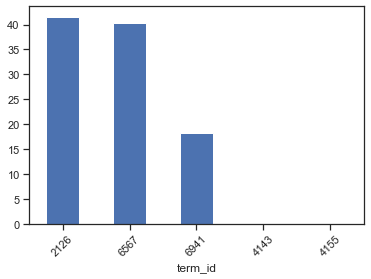

In [85]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [86]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [87]:
COMPS

,eig_val,3976,3440,2402,2521,10621,1043,1524,3385,5865,...,7885,8350,8648,9632,9075,479,6941,6567,2126,exp_var
PC0,6.415178e-06,0.047617,6.385737e-01,2.876854e-02,3.984263e-01,7.720324e-03,3.198326e-01,5.053765e-02,2.129923e-02,2.816274e-01,...,0.000827,0.000827,0.000827,0.000827,0.000827,8.272753e-04,8.272753e-04,8.272753e-04,8.272753e-04,41.58
PC1,6.207775e-06,-0.689692,4.564380e-02,-4.166890e-01,2.847861e-02,-1.388337e-03,2.286091e-02,2.048679e-03,-3.085020e-01,2.013008e-02,...,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,-2.543499e-04,-2.543499e-04,-2.543499e-04,-2.543499e-04,40.23
PC2,2.806171e-06,-0.005808,-2.185102e-02,-3.509252e-03,-1.363354e-02,5.093703e-01,-1.094419e-02,4.089998e-01,-2.598128e-03,-9.636861e-03,...,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,-3.019825e-05,-3.019825e-05,-3.019825e-05,-3.019825e-05,18.19
PC3,1.996649e-42,0.000000,-5.214386e-17,1.667226e-17,-3.632116e-17,-2.646698e-16,2.364925e-16,9.820880e-17,-1.711009e-16,-1.483609e-16,...,-0.006184,0.024608,-0.016172,0.010228,0.025696,-2.337771e-13,-2.324701e-13,-1.510275e-13,1.234523e-13,0.00
PC4,2.023939e-42,0.000000,4.234071e-17,-3.087960e-17,3.416539e-17,1.648853e-16,-9.174713e-17,-3.523799e-17,1.276018e-16,8.206753e-17,...,-0.041251,-0.018389,0.018781,-0.018515,0.045651,1.110930e-13,1.149436e-13,7.803793e-14,-8.009374e-14,0.00
PC5,2.012984e-42,0.000000,-8.705247e-17,5.300421e-17,-6.917493e-17,-3.642236e-16,2.491935e-16,9.360664e-17,-2.659735e-16,-1.829268e-16,...,-0.019830,0.003061,-0.019998,0.012500,-0.033081,-2.222446e-13,-2.693366e-13,-1.839306e-13,1.840310e-13,0.00
PC6,2.012400e-42,0.000000,-2.081771e-17,1.904530e-17,-1.116100e-17,-1.185903e-16,8.400003e-17,2.327662e-17,-9.068121e-17,-6.200143e-17,...,0.008756,-0.001747,-0.001908,-0.002241,-0.000656,-1.533037e-13,-9.058179e-14,-7.107363e-14,6.046828e-14,0.00
PC7,2.004872e-42,0.000000,2.763291e-17,-2.034777e-17,2.069266e-17,1.207255e-16,-8.109694e-17,-3.337449e-17,9.165627e-17,6.052636e-17,...,0.007171,-0.036115,0.010578,-0.015687,0.044366,1.223491e-13,9.054919e-14,6.196925e-14,-5.616827e-14,0.00
PC8,2.001303e-42,0.000000,-6.003783e-17,4.526494e-17,-4.641753e-17,-2.619518e-16,1.592306e-16,6.020085e-17,-1.960079e-16,-1.305904e-16,...,-0.022630,0.007481,0.002604,0.048700,0.008069,-1.835728e-13,-1.890560e-13,-1.271475e-13,1.236227e-13,0.00
PC9,1.991244e-42,0.000000,5.226410e-18,-6.264802e-18,2.326190e-18,4.520831e-17,-2.875152e-17,-1.472494e-17,3.152660e-17,2.112401e-17,...,-0.012552,-0.011401,0.003491,0.009930,-0.027084,-6.210266e-14,3.429019e-14,2.974922e-14,-1.744096e-14,0.00


In [88]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [89]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [90]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)

Books PC0+ string sexes universe undisputed surmounting surer weddingday trifler smacked tip
Books PC0- elizabeth darcy bennet jane bingley collins wickham lydia lizzy longbourn
Books PC1+ fanny crawford edmund thomas bertram rushworth norris mansfield grant crawfords
Books PC1- elizabeth darcy bennet jane bingley collins wickham lydia lizzy longbourn


In [91]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

term_id
2126        conquer
6567          meets
6941     neglecting
4143           firs
4155      fittingup
4168       flatness
4174      flavoured
4181    flirtations
4191         florid
4095          fiend
Name: term_str, dtype: object

In [92]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)

In [93]:
DCM

PC0       PC1       PC2           PC3  \
genre author book_id                                               
n     austen 121      0.000082 -0.000014  0.002368 -5.293956e-23   
             141      0.000251 -0.003515 -0.000013  4.764560e-22   
             42671    0.003572  0.000247 -0.000053 -6.617445e-23   

                               PC4           PC5           PC6           PC7  \
genre author book_id                                                           
n     austen 121      1.017432e-21  3.705769e-22  2.329341e-21 -6.617445e-22   
             141      6.948317e-23  6.352747e-22  5.293956e-23  5.029258e-22   
             42671    9.562208e-22  1.012469e-21 -2.729696e-22  9.926167e-22   

                               PC8           PC9  
genre author book_id                              
n     austen 121      1.058791e-22  2.572532e-21  
             141     -7.940934e-23 -1.526975e-21  
             42671    1.350694e-23  4.566287e-23

In [94]:
LIB

,book_id,book_title,book_file,author,title,year,genre
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n


In [95]:
DCM = LIB.merge(DCM, on='book_id')

In [96]:
DCM

,book_id,book_title,book_file,author,title,year,genre,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n,0.000251,-0.003515,-0.000013,4.764560e-22,6.948317e-23,6.352747e-22,5.293956e-23,5.029258e-22,-7.940934e-23,-1.526975e-21
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n,0.000082,-0.000014,0.002368,-5.293956e-23,1.017432e-21,3.705769e-22,2.329341e-21,-6.617445e-22,1.058791e-22,2.572532e-21
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n,0.003572,0.000247,-0.000053,-6.617445e-23,9.562208e-22,1.012469e-21,-2.729696e-22,9.926167e-22,1.350694e-23,4.566287e-23


In [98]:
DCM['doc'] = DCM.apply(lambda x: "{}-{}-{}".format(x.genre, x.author_x, x.title_y[1]), 1)

AttributeError: 'Series' object has no attribute 'author_x'

In [ ]:
DCM

,book_id,book_title_x,book_file_x,author_x,title_x,year_x,genre,book_title_y,book_file_y,author_y,...,title_y,year_y,genre_x,book_title_y,book_file_y,author_y,title_y,year_y,genre_y,doc
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,...,Mansfield Park,1814,n,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n,n-author_x austen\nauthor_x austen\nauth...
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,...,Northanger Abbey,1803,n,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n,n-author_x austen\nauthor_x austen\nauth...
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,...,Pride and Prejudice,1813,n,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n,n-author_x austen\nauthor_x austen\nauth...


In [ ]:
import plotly.express as px

In [ ]:
def vis_pcs(M, a, b, label='book', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='book_id', marginal_x='box')
    fig.show()

In [ ]:
vis_pcs(DCM, 0, 1, label = 'genre')

In [ ]:
vis_pcs(DCM, 1, 2, label = 'genre')